In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(f'Number of words in the file : {len(words)}')

# Building VOCAB
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
#print(itos)
print(f"vocab size is : {vocab_size}")

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Number of words in the file : 32084
vocab size is : 27


In [2]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])  

torch.Size([182603, 3]) torch.Size([182603])
torch.Size([23085, 3]) torch.Size([23085])
torch.Size([22834, 3]) torch.Size([22834])


### Linear Layer

In [3]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

### BatchNorm1d Layer

In [4]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

### Activation

In [5]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

## Model

In [56]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
#----Layer 1------
  Linear(n_embd * block_size, n_hidden, bias=False), 
  #BatchNorm1d(n_hidden), 
  Tanh(),
# ---Layer 2 -----
  Linear(n_hidden, n_hidden, bias=False), 
  #BatchNorm1d(n_hidden),
  Tanh(),
# ---Layer 3 ----- 
  Linear(n_hidden, n_hidden, bias=False), 
  #BatchNorm1d(n_hidden),
  Tanh(),
# ---Layer 4 ----- 
  Linear(n_hidden, n_hidden, bias=False),
  #BatchNorm1d(n_hidden),
  Tanh(),
# ---Layer 5 -----
  Linear(n_hidden, n_hidden, bias=False),
  #BatchNorm1d(n_hidden), 
  Tanh(),
# ---Layer 6 -----
  Linear(n_hidden, vocab_size, bias=False), 
  #BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

45970


In [57]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers: 
        x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers: 
        layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'loss -->{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

loss -->      0/ 200000: 3.3009


### Tanh saturation Visualisation at different layers

layer 1 (      Tanh): mean -0.01, std 0.43, saturated: 0.06%
layer 3 (      Tanh): mean -0.01, std 0.20, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.10, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.05, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.02, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

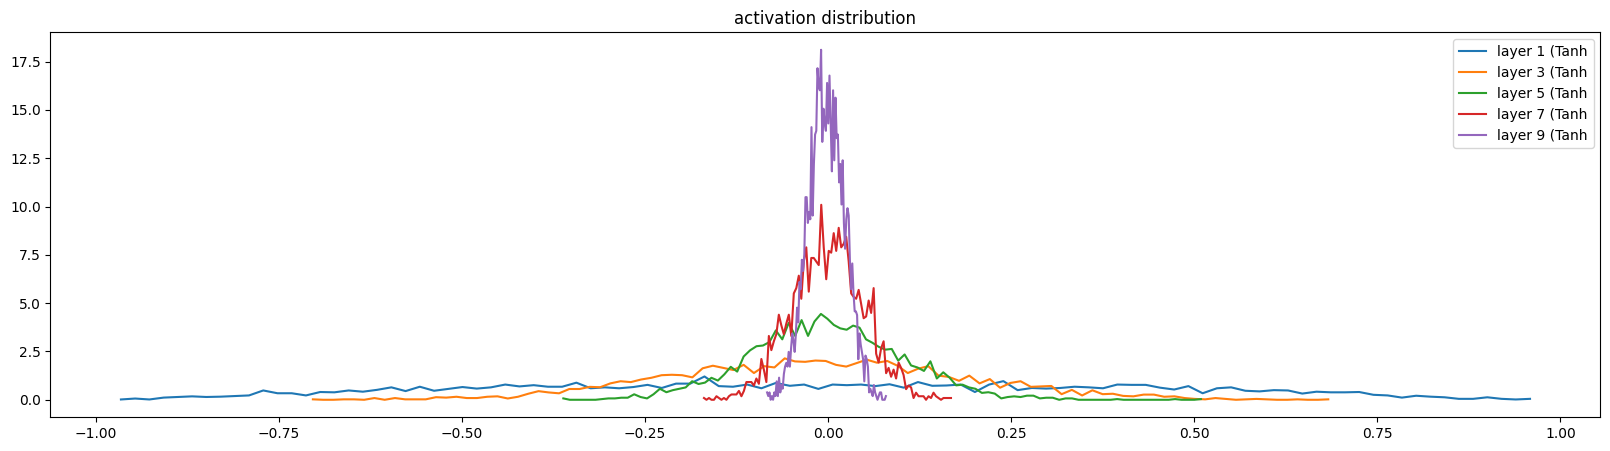

In [36]:
# for gain = 0.1
# visualize histograms
plt.figure(figsize=(20, 5)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.02, std 0.77, saturated: 22.69%
layer 3 (      Tanh): mean -0.03, std 0.69, saturated: 9.62%
layer 5 (      Tanh): mean +0.01, std 0.67, saturated: 8.03%
layer 7 (      Tanh): mean -0.01, std 0.65, saturated: 5.81%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.09%


Text(0.5, 1.0, 'activation distribution')

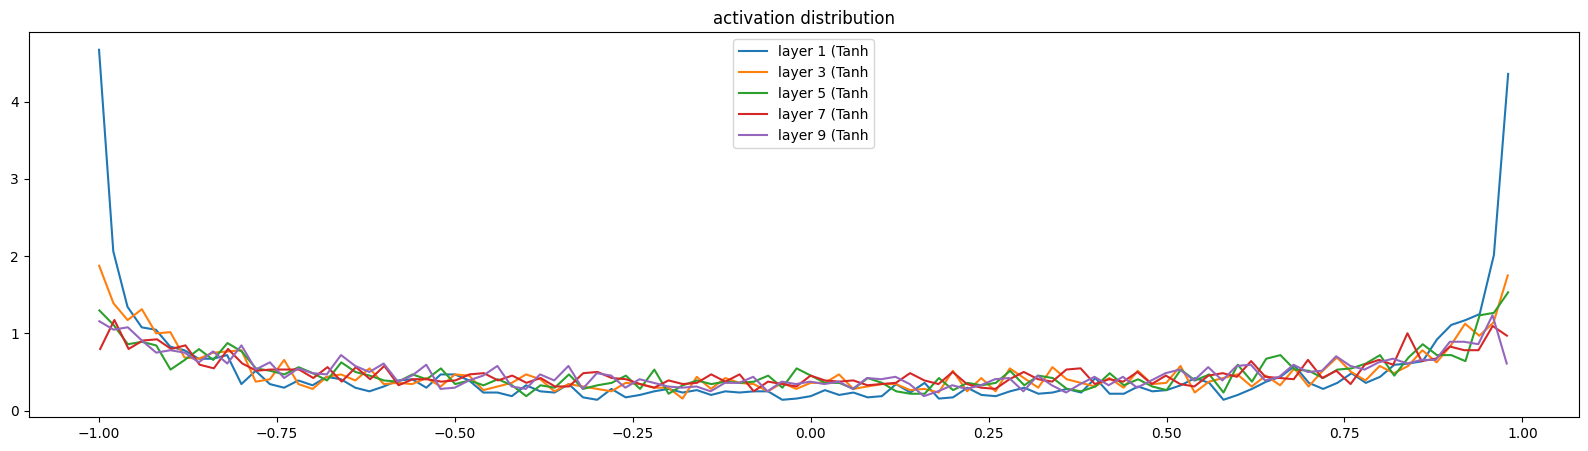

In [32]:
# for gain = 0.1
# visualize histograms
plt.figure(figsize=(20, 5)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.01, std 0.64, saturated: 4.06%
layer 3 (      Tanh): mean -0.02, std 0.49, saturated: 0.19%
layer 5 (      Tanh): mean +0.01, std 0.41, saturated: 0.06%
layer 7 (      Tanh): mean +0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.02, std 0.33, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

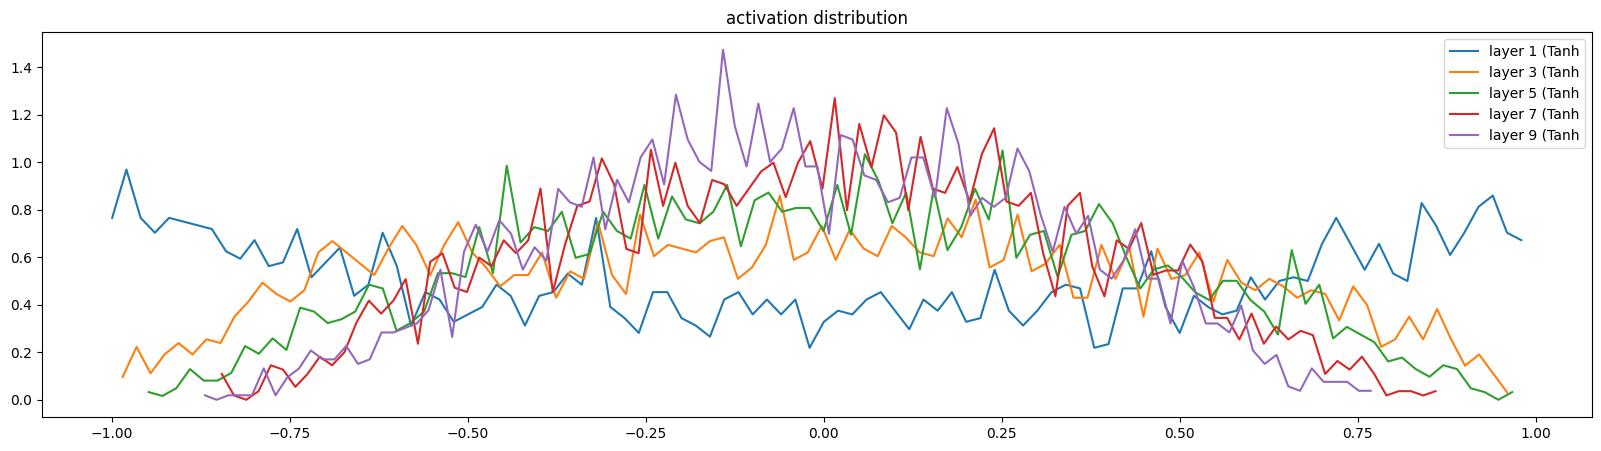

In [26]:
# for gain = 1
# visualize histograms
plt.figure(figsize=(20, 5)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.02, std 0.87, saturated: 51.31%
layer 3 (      Tanh): mean -0.03, std 0.84, saturated: 40.94%
layer 5 (      Tanh): mean +0.00, std 0.84, saturated: 42.03%
layer 7 (      Tanh): mean -0.01, std 0.83, saturated: 39.38%
layer 9 (      Tanh): mean -0.01, std 0.84, saturated: 41.38%


Text(0.5, 1.0, 'activation distribution')

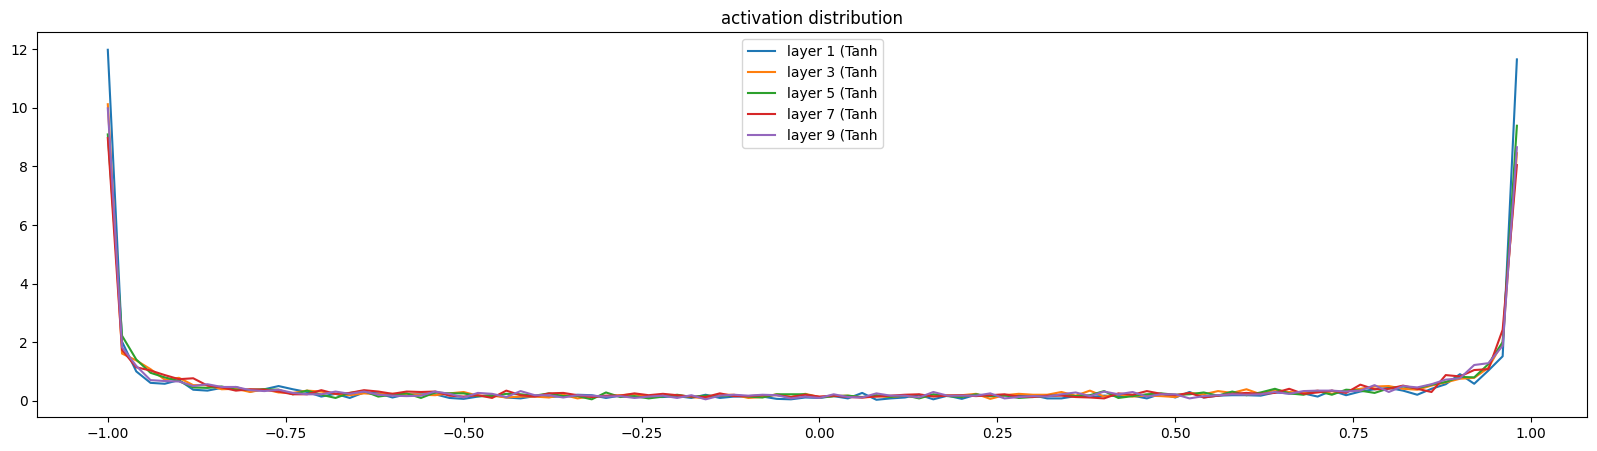

In [23]:
# for gain = 3
# visualize histograms
plt.figure(figsize=(20, 5)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.02, std 0.77, saturated: 22.69%
layer 3 (      Tanh): mean -0.03, std 0.69, saturated: 9.62%
layer 5 (      Tanh): mean +0.01, std 0.67, saturated: 8.03%
layer 7 (      Tanh): mean -0.01, std 0.65, saturated: 5.81%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.09%


Text(0.5, 1.0, 'activation distribution')

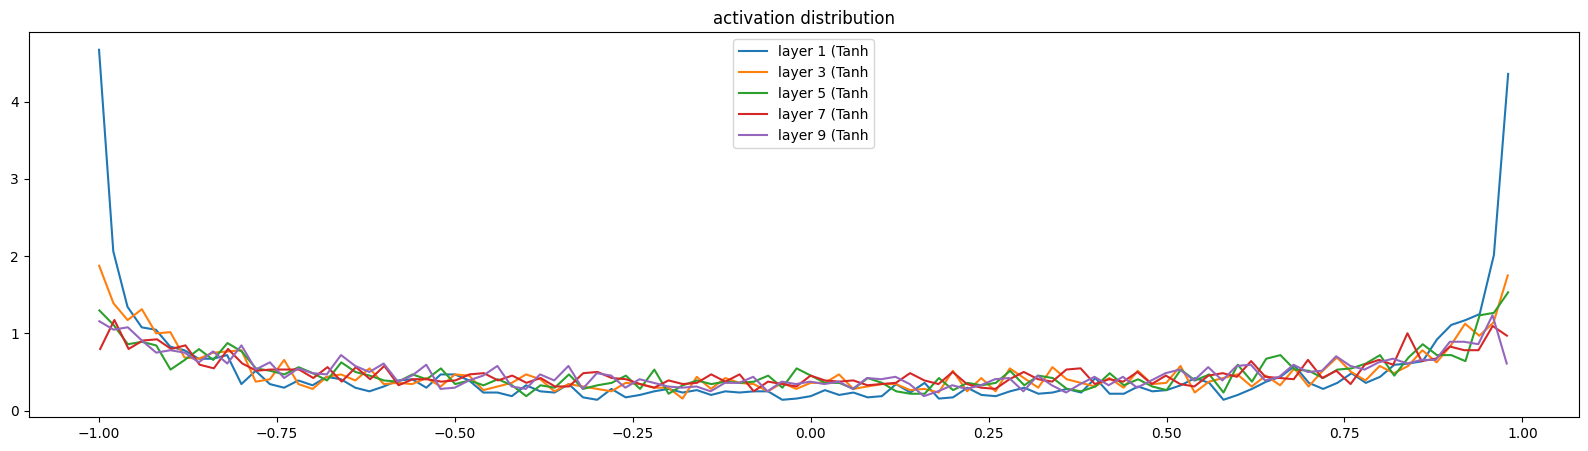

In [29]:
# for gain = 5/3
# visualize histograms
plt.figure(figsize=(20, 5)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

**gain = 5/3 is perfect here**

### Gradients Visulisation

layer 1 (      Tanh): mean +0.000000, std 1.828286e-05
layer 3 (      Tanh): mean +0.000001, std 3.849349e-05
layer 5 (      Tanh): mean +0.000004, std 7.850803e-05
layer 7 (      Tanh): mean +0.000002, std 1.536417e-04
layer 9 (      Tanh): mean +0.000000, std 3.021009e-04


Text(0.5, 1.0, 'gradient distribution')

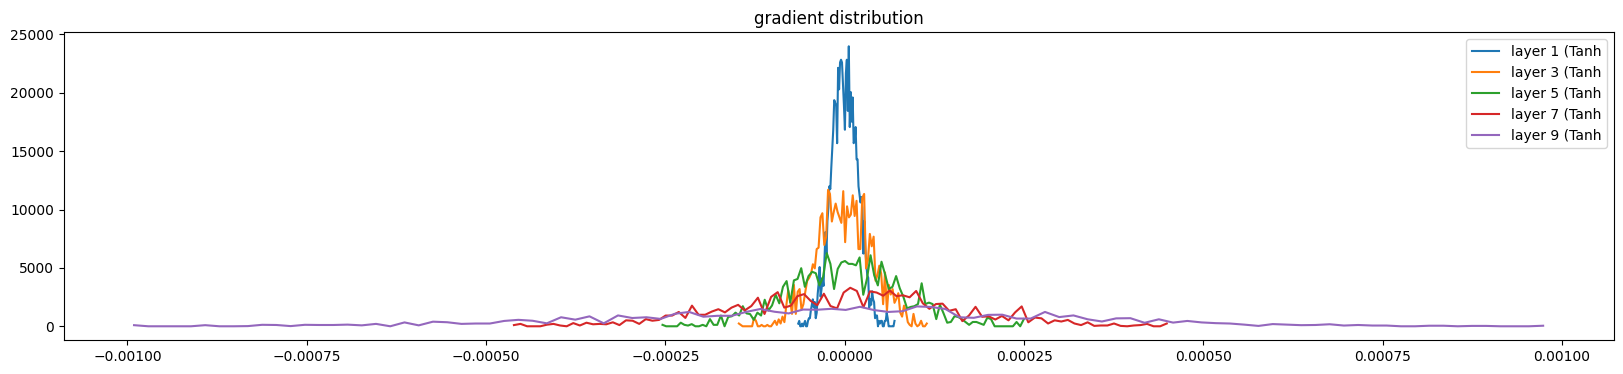

In [37]:
# visualize histograms

# gain = 0.5
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

## Gradients going to zero

layer 1 (      Tanh): mean +0.000002, std 1.673564e-04
layer 3 (      Tanh): mean +0.000004, std 2.099112e-04
layer 5 (      Tanh): mean +0.000011, std 2.504596e-04
layer 7 (      Tanh): mean +0.000004, std 2.756795e-04
layer 9 (      Tanh): mean +0.000001, std 3.021168e-04


Text(0.5, 1.0, 'gradient distribution')

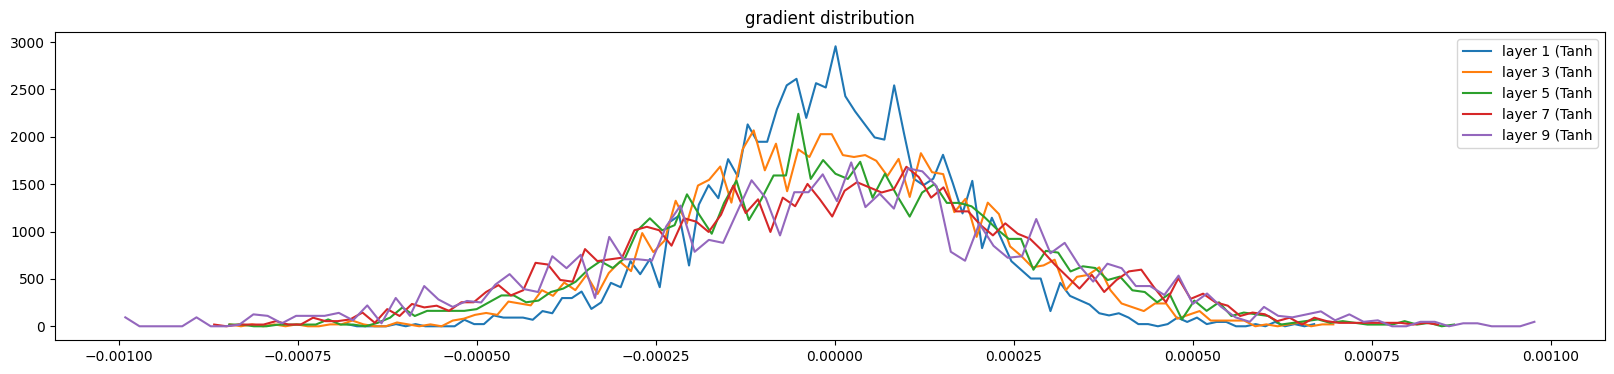

In [40]:
# visualize histograms

# gain = 1
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

layer 1 (      Tanh): mean -0.000004, std 3.934103e-04
layer 3 (      Tanh): mean +0.000009, std 3.773801e-04
layer 5 (      Tanh): mean +0.000011, std 3.618587e-04
layer 7 (      Tanh): mean +0.000005, std 3.245938e-04
layer 9 (      Tanh): mean +0.000001, std 3.021623e-04


Text(0.5, 1.0, 'gradient distribution')

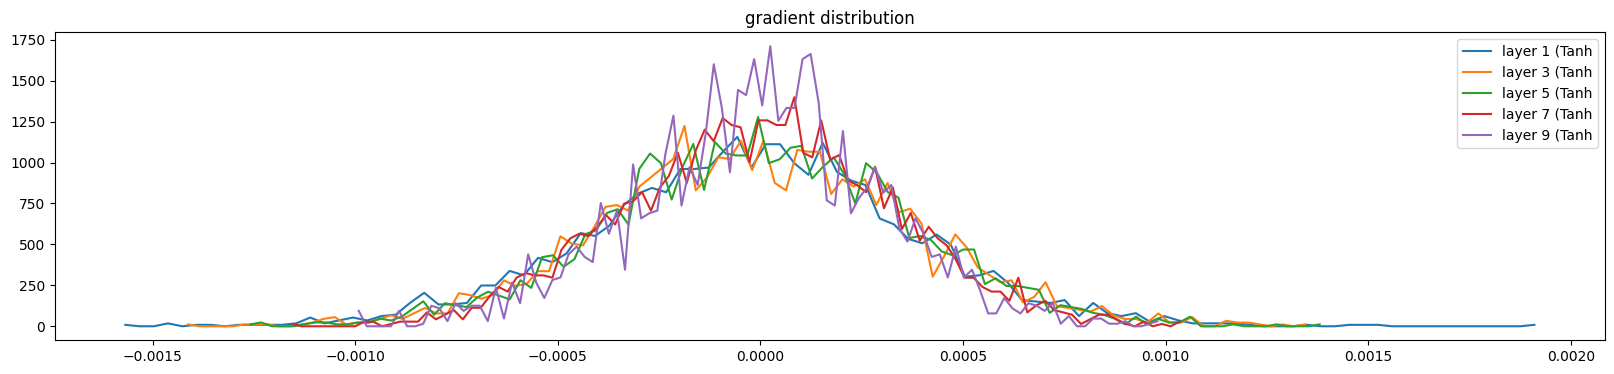

In [44]:
# visualize histograms

# gain = 5/3
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

### What if we did not use any tanh. just linear layer (comment out above to run)
Definitely do not want this

layer 0 (    Linear): mean -0.03, std 1.75, saturated: 58.25%
layer 1 (    Linear): mean -0.12, std 2.89, saturated: 71.94%
layer 2 (    Linear): mean +0.09, std 4.94, saturated: 83.19%
layer 3 (    Linear): mean +0.23, std 7.83, saturated: 91.00%
layer 4 (    Linear): mean -1.00, std 13.22, saturated: 93.91%


Text(0.5, 1.0, 'activation distribution')

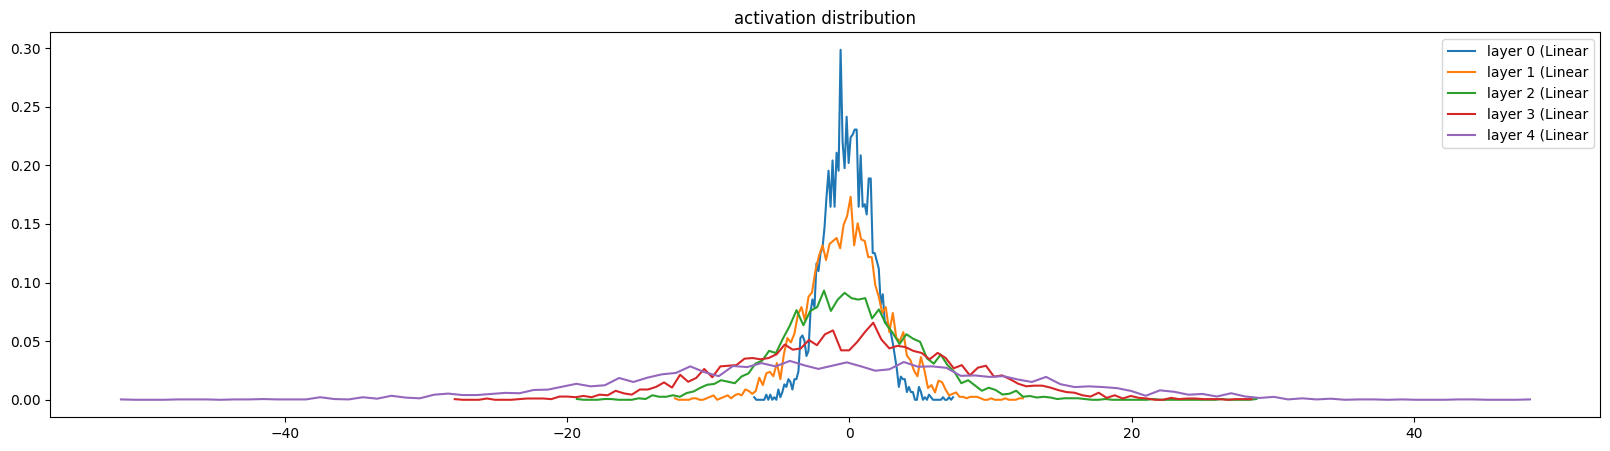

In [51]:
# for gain = 5/3
# visualize histograms
plt.figure(figsize=(20, 5)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 0 (    Linear): mean +0.000051, std 2.577264e-03
layer 1 (    Linear): mean +0.000058, std 1.572009e-03
layer 2 (    Linear): mean +0.000041, std 9.446509e-04
layer 3 (    Linear): mean -0.000001, std 5.453222e-04
layer 4 (    Linear): mean +0.000003, std 3.172942e-04


Text(0.5, 1.0, 'gradient distribution')

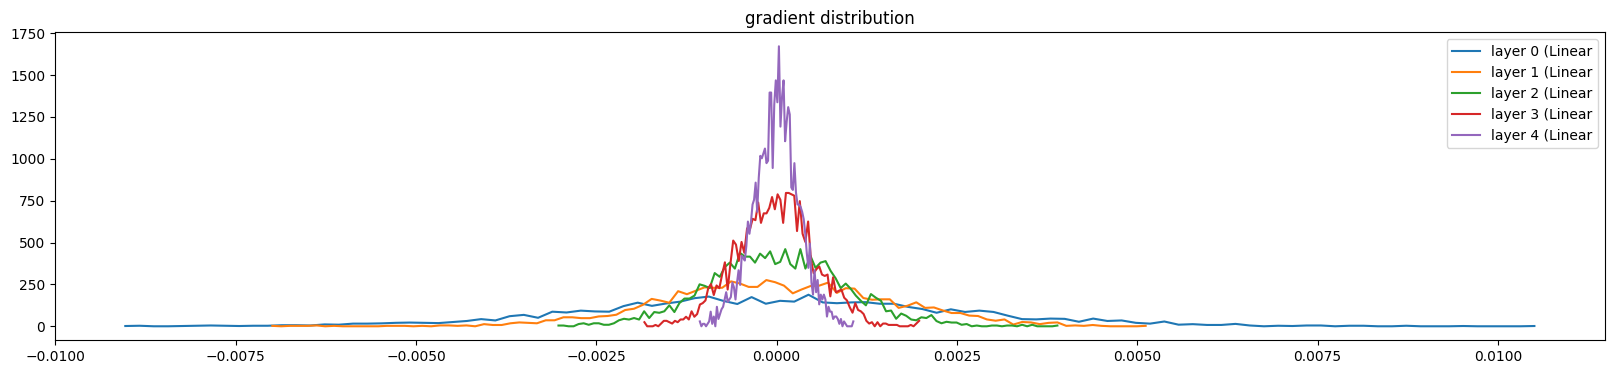

In [52]:
# visualize histograms

# gain = 5/3
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

erbuagmyazzhzevvndhfyalwqetvrsjejdrljg.
ozcjedgeliihsmpqppalekepxvqnpxarqeptzcmhvqrpcn.
szdbvrgxhgmjest.
jcjrwjkjqqxntpucfkubzmgvdtrxyqqufmehg.
kmejqvskkydmzhjl.
cakyybsufpzbjglvjurenjcrtvwsvevoecmpfhdxrfqnxoeobhggptixjsfcueywwkhmreolbiilqiif.
wvpkxwvlla.
ortabfsztjndgoizvsblitgfkxvbssivpu.
meewrkepxcmvyhxavttudkjgczekhgcgtipvtudt.
iwbddihzvorlq.
cjakepxugniagcrpppfmiipzjgvonxet.
jydnblkskzporygnogsvmwosfzpbsyknvmjcxtkncjbmu.
jtew.
aow.
copmrlxkzdcqbcep.
ccdfibsnipimhtecmokagouwzlrurdckappomtcokwxtnbnzkdphfam.
xcojfffuncxzhosy.
sj.
ascnpc.
cilwtanczhndtebimm.


# Applying Batch Norm

In [65]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
#----Layer 1------
  Linear(n_embd * block_size, n_hidden, bias=False), 
  BatchNorm1d(n_hidden), 
  Tanh(),
# ---Layer 2 -----
  Linear(n_hidden, n_hidden, bias=False), 
  BatchNorm1d(n_hidden),
  Tanh(),
# ---Layer 3 ----- 
  Linear(n_hidden, n_hidden, bias=False), 
  BatchNorm1d(n_hidden),
  Tanh(),
# ---Layer 4 ----- 
  Linear(n_hidden, n_hidden, bias=False),
  BatchNorm1d(n_hidden),
  Tanh(),
# ---Layer 5 -----
  Linear(n_hidden, n_hidden, bias=False),
  BatchNorm1d(n_hidden), 
  Tanh(),
# ---Layer 6 -----
  Linear(n_hidden, vocab_size, bias=False), 
  BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  
  layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [ ]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers: 
        x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers: 
        layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'loss -->{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  #break

loss -->      0/ 100000: 3.2902
loss -->  10000/ 100000: 2.1199
loss -->  20000/ 100000: 2.4404
loss -->  30000/ 100000: 2.1426
loss -->  40000/ 100000: 2.2232


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 5 (      Tanh): mean -0.01, std 0.63, saturated: 2.41%
layer 8 (      Tanh): mean -0.00, std 0.63, saturated: 2.69%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.44%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.38%


Text(0.5, 1.0, 'activation distribution')

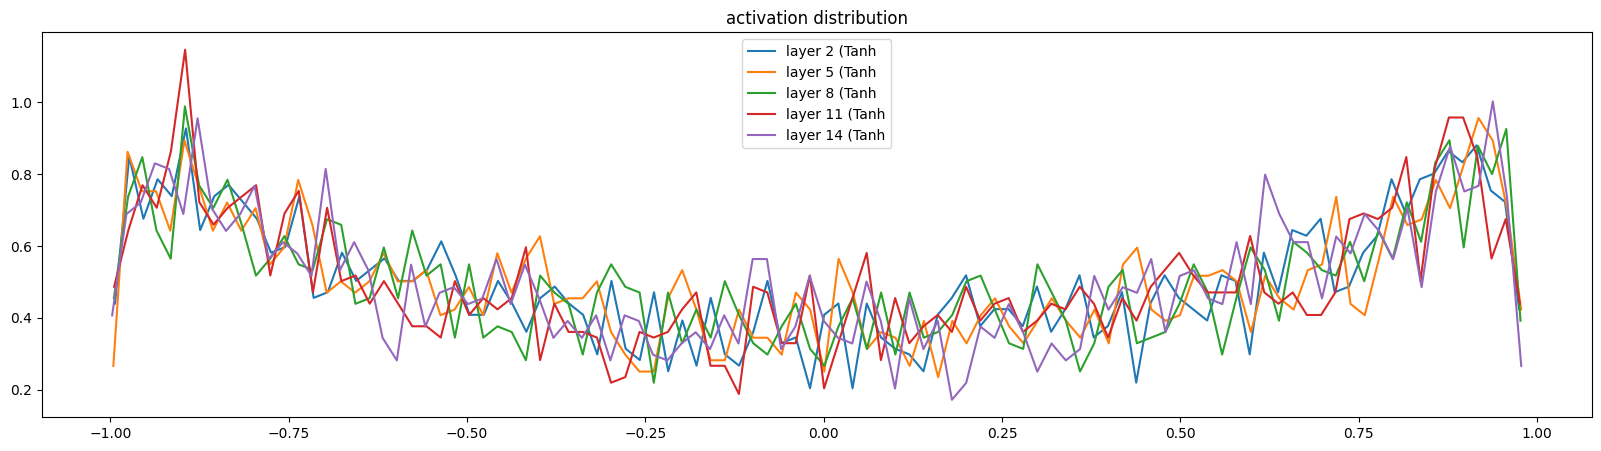

In [63]:
# for gain = 5/3
# visualize histograms
plt.figure(figsize=(20, 5)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 8.042244e-04
layer 5 (      Tanh): mean -0.000000, std 6.985336e-04
layer 8 (      Tanh): mean -0.000000, std 6.320258e-04
layer 11 (      Tanh): mean -0.000000, std 5.577374e-04
layer 14 (      Tanh): mean +0.000000, std 5.036201e-04


Text(0.5, 1.0, 'gradient distribution')

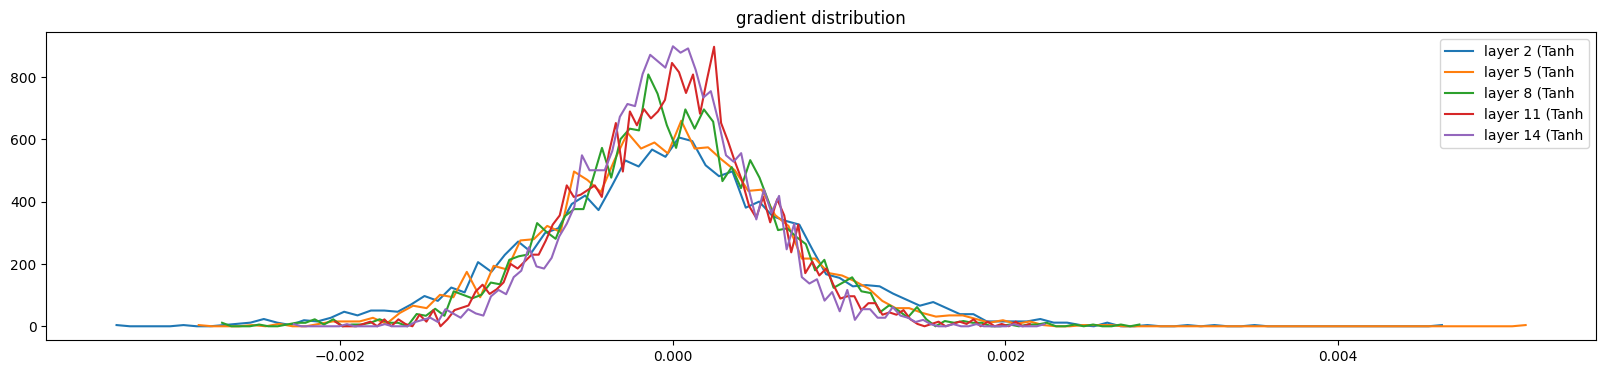

In [64]:
# visualize histograms

# gain = 5/3
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

In [13]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 3.289337158203125
val 3.2896053791046143
